OK quantidade de pedidos baseado no horário do dia -> ajuda a entender horários de pico

OK quantida de pedidos por dia da semana -> ajuda a entender demanda por dia da semana

OK pedidos por estado -> ajuda a entender demanda

tempo médio por estado -> ajuda a entender se o tempo de entrega está relacionado com a cidade do estabelecimento

OK meios de pagamentos mais usados para pagar -> serve mais como um insight legal pra mostrar pro cliente

OK separar pedidos por CANCELADO ou FEITO e analisar regiões onde mais ocorreram, horários e etc

tempo médio por driver_type

tempo médio por driver_modal

pedidos por channel type

diagrama de fluxo para visualizar hubs com maior cancelamento e delivered

diagrama de fluxo para visualizar estados com maior cancelamento e delivered

diagrama de fluxo para visualizar lojas com maior cancelamento e delivered

# Funções

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil  # Importar a função ceil

from dash import Dash, dcc, html, Input, Output

pd.options.display.max_columns=50 
pd.options.display.max_rows=80

In [2]:
def create_multiple_boxplots(data_frame, columns_for_boxplot, titles=None, num_boxplots_per_row=2):
    # Calcular a quantidade;
    num_boxplots = len(columns_for_boxplot)
    num_rows = (num_boxplots + num_boxplots_per_row - 1) // num_boxplots_per_row

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_boxplots_per_row, subplot_titles=titles)

    # Loop para ir montando todos os gráficos em boxplot
    for idx, column in enumerate(columns_for_boxplot):
        row_idx = idx // num_boxplots_per_row + 1
        col_idx = idx % num_boxplots_per_row + 1

        data = data_frame[column]
        box = go.Box(y=data, name=column)

        fig.add_trace(box, row=row_idx, col=col_idx)

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)

    # Plotar os gráficos
    fig.show()

In [3]:
def plotar_distribuicoes(data_frame, columns_for_distribution, num_distributions_per_row=2):
    # Calcular a quantidade
    num_distributions = len(columns_for_distribution)
    num_rows = ceil(num_distributions / num_distributions_per_row)

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_distributions_per_row)

    # Loop para ir montando todos os gráficos de distribuição
    for idx, column in enumerate(columns_for_distribution):
        dados = data_frame[column].dropna()  # Remover valores ausentes

        # Criar o gráfico de histograma
        histogram_data = go.Histogram(x=dados, nbinsx=30, name=f'Histograma - {column}')

        # Adicionar ao subplot
        fig.add_trace(histogram_data,
                      row=(idx // num_distributions_per_row) + 1, col=(idx % num_distributions_per_row) + 1)

    # Atualizar o layout com títulos e legendas adequadas
    for idx, column in enumerate(columns_for_distribution):
        row_idx = (idx // num_distributions_per_row) + 1
        col_idx = (idx % num_distributions_per_row) + 1

        # Adicionar título ao subplot
        fig.update_xaxes(title_text=f'{column}', row=row_idx, col=col_idx)
        fig.update_yaxes(title_text='Quantidade', row=row_idx, col=col_idx)  # Adicionar título ao eixo Y

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)  # Remover a legenda

    # Plotar os gráficos
    fig.show()

In [4]:
def find_correlated_columns(df, interval):
    """
    Encontra e exibe as correlações entre colunas de um DataFrame.

    Parâmetros:
    - df: DataFrame pandas
    - intervalo de correlação desejado (uma tupla de dois valores)

    Retorna:
    - Lista de tuplas representando pares de colunas correlacionadas.
    """
    correlation_matrix = df.corr(numeric_only=True)
    correlated_columns = []

    # Iterar sobre as combinações de colunas para encontrar correlações
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr = correlation_matrix.iloc[i, j]
            if interval[0] <= abs(corr) <= interval[1]:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                correlated_columns.append((col1, col2))
                print(f"Correlação entre {col1} e {col2}: {corr}")

    # Plotar um mapa de calor da matriz de correlação
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='BrBG')
    plt.title('Matriz de Correlação')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    return correlated_columns

In [5]:
def correlacao_com_variavel_alvo(df, target_variable, nivel="forte", top_n=5):
    """
    Imprime as n features com as maiores correlações com uma variável alvo, com base no nível escolhido.

    Parâmetros:
    - df: DataFrame pandas.
    - target_variable: String, nome da variável alvo.
    - nivel: String que define o critério de correlação ("forte", "fraca", etc.).
    - top_n: Número inteiro, quantidade de features a serem impressas.

    Retorna:
    - Nenhum (imprime as correlações).
    """
    correlation_matrix = df.corr(numeric_only=True)

    # Filtra as correlações com base no nível escolhido
    if nivel.lower() == "forte":
        filtered_correlations = correlation_matrix[((correlation_matrix >= 0.7) & (correlation_matrix < 1.0)) | ((correlation_matrix <= -0.7) & (correlation_matrix > -1.0))]
    else:
        raise ValueError("Nível não suportado. Atualmente, apenas 'forte' é suportado.")

    # Filtra as correlações com a variável alvo
    correlations_with_target = filtered_correlations[target_variable].sort_values(ascending=False)

    # Pegar as n maiores correlações
    top_n_correlations = correlations_with_target.head(top_n)

    # Imprimir as n maiores correlações com a variável alvo
    print(f"As {top_n} maiores correlações com '{target_variable}' ({nivel}):")
    for feature, correlation in top_n_correlations.items():
        print(f"{feature}: {correlation}")


In [6]:
def cria_fluxograma(df, origem, destino, intermediario, titulo, tam_fonte):
    df_temp1 = df.groupby([origem, intermediario])['order_status'].count().reset_index()
    df_temp1.columns = ['source', 'target', 'value']

    df_temp2 = df.groupby([intermediario, destino])['delivery_status'].count().reset_index()
    df_temp2.columns = ['source', 'target', 'value']

    if destino == 'order_status':
        df_temp2['target'] = df_temp2['target'].map({'CANCELED': 'Cancelado', 'FINISHED': 'Finalizado'})
    else:
        pass

    links = pd.concat([df_temp1, df_temp2], axis=0)

    unique_source_target = list(pd.unique(links[['source', 'target']].values.ravel('K')))

    mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

    links['source'] = links['source'].map(mapping_dict)
    links['target'] = links['target'].map(mapping_dict)

    links_dict = links.to_dict(orient='list')

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness = 20,
            line = dict(color = 'black', width = 0.5),
            label = unique_source_target,
            color = 'blue'
        ),
        link = dict(
            source = links_dict['source'],
            target = links_dict['target'],
            value = links_dict['value']
        )
    )])

    return fig.update_layout(title_text = titulo, font_size=tam_fonte)

# Análise Exploratória

In [7]:
df1 = pd.read_csv('base_limpa1.csv', index_col=0)
df2 = pd.read_csv('base_limpa2.csv', index_col=0)

df = pd.concat([df1, df2])

In [8]:
df['order_date'] = pd.to_datetime(df['order_date'])
df_date = df.copy()

# Criando colunas para facilitar análises
df_date['minute'] = df['order_date'].dt.minute
df_date['hour'] = df['order_date'].dt.hour
df_date['day'] = df['order_date'].dt.day
df_date['month'] = df['order_date'].dt.month
df_date['year'] = df['order_date'].dt.year
df_date['weekday'] = df['order_date'].dt.weekday # Domingo é 0

In [9]:
df.head()

,hub_name,hub_city,hub_state,store_name,store_segment,store_plan_price,driver_modal,driver_type,delivery_distance_meters,delivery_status,payment_amount,payment_fee,payment_method,payment_status,channel_name,channel_type,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_ready,order_moment_collected,order_moment_in_expedition,order_moment_delivering,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,order_date
0,PURPLE SHOPPING,RIO DE JANEIRO,RJ,RA VACAI EUSEU I AMACAI,FOOD,49.0,MOTOBOY,LOGISTIC OPERATOR,1389.0,DELIVERED,126.65,1.90,ONLINE,PAID,FOOD PLACE,MARKETPLACE,FINISHED,116,9,7.0,2021-02-25 19:21:59,2021-02-25 19:23:49,2021-02-25 19:26:12,2021-02-25 19:26:49,2021-02-25 19:27:27,2021-02-25 19:34:10,2021-02-25 19:45:13,0.0,6.0,4.0,1.0,7.0,11.0,23.0,2021-02-25 19:21:00
1,AVENUE SHOPPING,S�O PAULO,SP,PIGUE PIPACO,FOOD,49.0,BIKER,FREELANCE,387.0,DELIVERED,NaN,NaN,NaN,NaN,FOOD PLACE,MARKETPLACE,FINISHED,21,0,5.0,2021-02-25 19:22:20,2021-02-25 19:23:22,2021-02-25 19:31:05,2021-02-25 19:34:45,2021-02-25 19:36:32,2021-02-25 19:38:56,2021-02-26 19:25:01,3.0,2.0,8.0,5.0,7.0,16.0,33.0,2021-02-25 19:22:00
2,AVENUE SHOPPING,S�O PAULO,SP,PAZZI ZUM,FOOD,49.0,BIKER,FREELANCE,555.0,DELIVERED,79.90,1.20,ONLINE,PAID,FOOD PLACE,MARKETPLACE,FINISHED,89,0,5.0,2021-02-25 19:22:26,2021-02-25 19:23:29,2021-02-25 19:36:55,2021-02-25 19:42:26,2021-02-25 19:42:27,2021-02-25 19:46:54,2021-02-25 20:00:55,5.0,4.0,14.0,5.0,9.0,14.0,38.0,2021-02-25 19:22:00
3,AVENUE SHOPPING,S�O PAULO,SP,PAZZI ZUM,FOOD,49.0,BIKER,FREELANCE,555.0,DELIVERED,10.00,0.00,VOUCHER,PAID,FOOD PLACE,MARKETPLACE,FINISHED,89,0,5.0,2021-02-25 19:22:26,2021-02-25 19:23:29,2021-02-25 19:36:55,2021-02-25 19:42:26,2021-02-25 19:42:27,2021-02-25 19:46:54,2021-02-25 20:00:55,5.0,4.0,14.0,5.0,9.0,14.0,38.0,2021-02-25 19:22:00
4,PAGODE SHOPPING,S�O PAULO,SP,SUPSIO,FOOD,49.0,MOTOBOY,FREELANCE,2578.0,DELIVERED,35.90,0.54,ONLINE,PAID,VELOCITY PLACE,MARKETPLACE,FINISHED,31,4,7.0,2021-02-25 19:23:21,2021-02-25 19:23:38,2021-02-25 19:34:50,2021-02-25 19:35:41,2021-02-25 19:36:30,2021-02-25 19:50:24,2021-02-25 19:59:52,0.0,13.0,11.0,1.0,15.0,9.0,36.0,2021-02-25 19:23:00


In [10]:
df['order_status'].nunique()

2

In [11]:
cria_fluxograma(df, origem='hub_state', destino='order_status', intermediario='payment_method', 
                titulo='Fluxo Cancelamento de Estados por Método de Pagamento', tam_fonte=10)

In [12]:
cria_fluxograma(df, origem='hub_name', destino='order_status', intermediario='hub_state', 
                titulo='Fluxo Cancelamento das Distribuições por Estados', tam_fonte=10)

In [13]:
cria_fluxograma(df_date, origem='hub_state', destino='order_status', intermediario='hour', 
                titulo='Fluxo Cancelamento dos Estados por Hora do Dia', tam_fonte=10)

In [14]:
cria_fluxograma(df, origem='hub_state', destino='order_status', intermediario='channel_type', 
                titulo='Fluxo Cancelamento dos Estados por Tipo de Canal', tam_fonte=10)

In [15]:
cria_fluxograma(df, origem='store_segment', destino='order_status', intermediario='channel_type', 
                titulo='Fluxo Cancelamento dos Segmentos por Tipo de Canal', tam_fonte=10)

In [16]:
cria_fluxograma(df, origem='channel_type', destino='order_status', intermediario='store_segment', 
                titulo='Fluxo Cancelamento dos Tipos de Canais por Segmentos', tam_fonte=10)

In [17]:
cria_fluxograma(df, origem='payment_method', destino='order_status', intermediario='hub_state', 
                titulo='Fluxo Cancelamento dos Métodos de Pagamento por Estados', tam_fonte=10)

In [18]:
cria_fluxograma(df, origem='payment_method', destino='order_status', intermediario='store_segment', 
                titulo='Fluxo Cancelamento dos Métodos de Pagamento por Segmentos', tam_fonte=10)

In [19]:
cria_fluxograma(df, origem='hub_state', destino='order_status', intermediario='store_segment', 
                titulo='Fluxo Cancelamento dos Estados por Segmentos', tam_fonte=10)

In [20]:
df_temp1 = df.groupby(['hub_state', 'driver_modal'])['order_status'].count().reset_index()
df_temp1.columns = ['source', 'target', 'value']
df_temp1['target'] = df_temp1['target'].map({'BIKER': 'Ciclista', 'MOTOBOY': 'Motociclista'})

df_temp2 = df.groupby(['driver_modal', 'order_status'])['delivery_status'].count().reset_index()
df_temp2.columns = ['source', 'target', 'value']
df_temp2['source'] = df_temp2['source'].map({'BIKER': 'Ciclista', 'MOTOBOY': 'Motociclista'})
df_temp2['target'] = df_temp2['target'].map({'CANCELED': 'Cancelado', 'FINISHED': 'Finalizado'})

links = pd.concat([df_temp1, df_temp2], axis=0)

unique_source_target = list(pd.unique(links[['source', 'target']].values.ravel('K')))

mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

links['source'] = links['source'].map(mapping_dict)
links['target'] = links['target'].map(mapping_dict)

links_dict = links.to_dict(orient='list')

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness = 20,
        line = dict(color = 'black', width = 0.5),
        label = unique_source_target,
        color = 'blue'
    ),
    link = dict(
        source = links_dict['source'],
        target = links_dict['target'],
        value = links_dict['value']
    )
)])

fig.update_layout(title_text = 'Fluxo Cancelamento dos Estados por Tipo de Entregador', font_size=15)

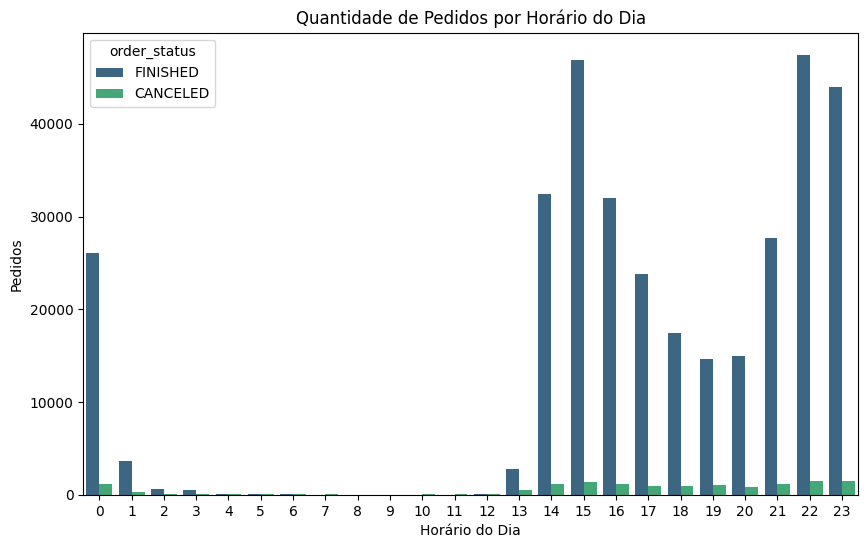

In [21]:
x_plot = 'hour'
plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date, palette='viridis', hue='order_status')
plt.xlabel('Horário do Dia')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Horário do Dia')
plt.show()

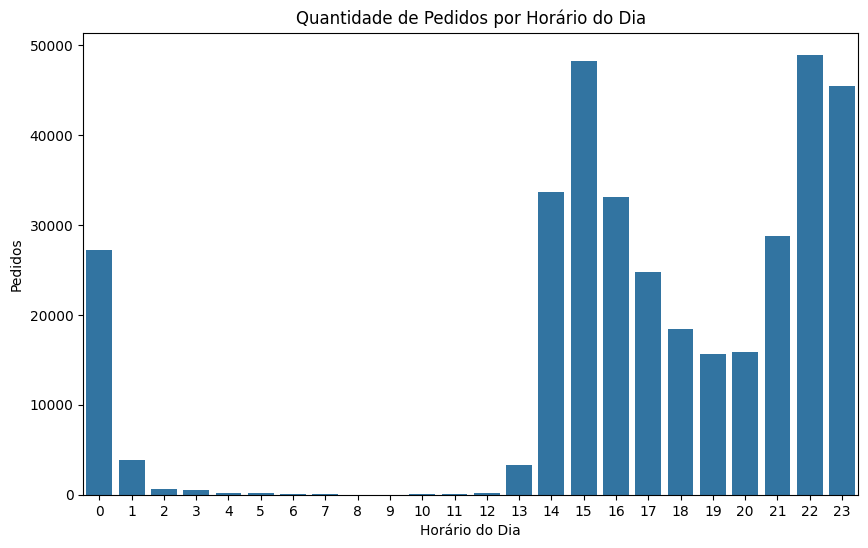

In [22]:
x_plot = 'hour'

plt.figure(figsize=(10,6))
#sns.countplot(x=x_plot, data=df, hue=x_plot, legend=False, palette='viridis')
sns.countplot(x=x_plot, data=df_date)
plt.xlabel('Horário do Dia')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Horário do Dia')
plt.show()

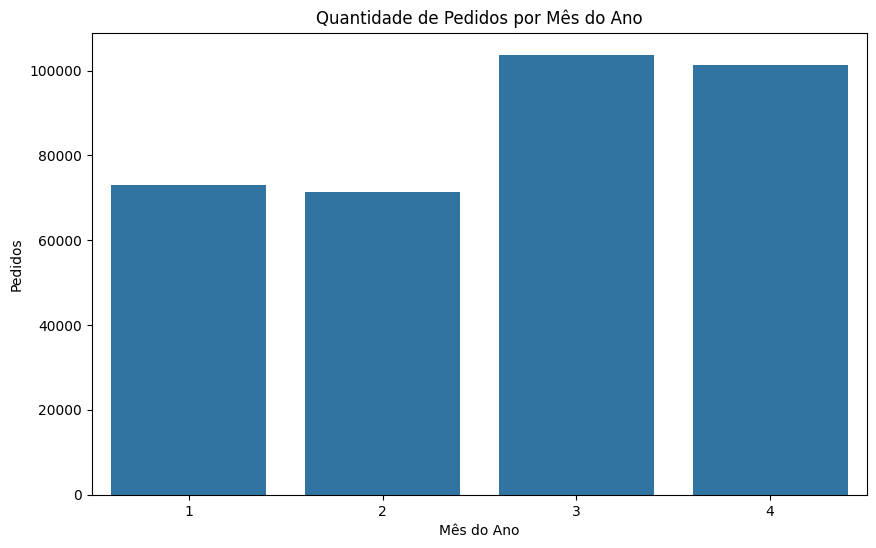

In [23]:
x_plot = 'month'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date)
plt.xlabel('Mês do Ano')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Mês do Ano')
plt.show()

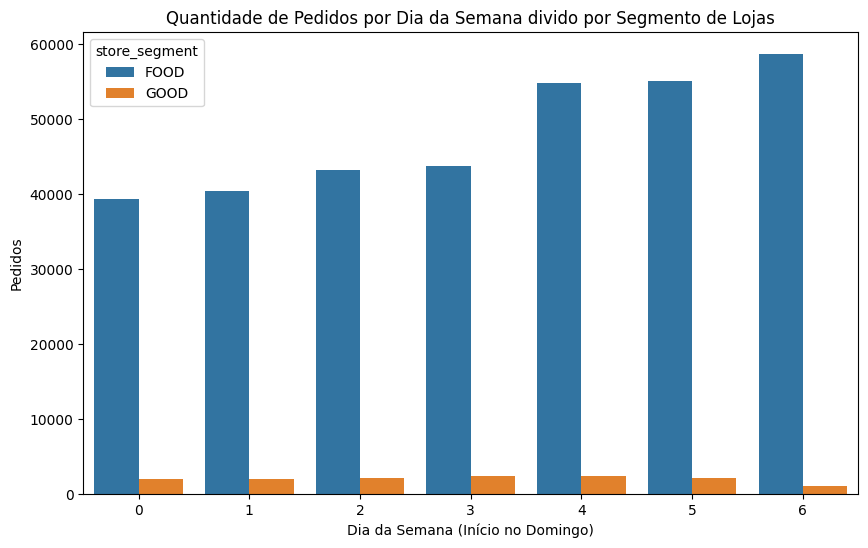

In [24]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date, hue='store_segment')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Dia da Semana divido por Segmento de Lojas')
plt.show()

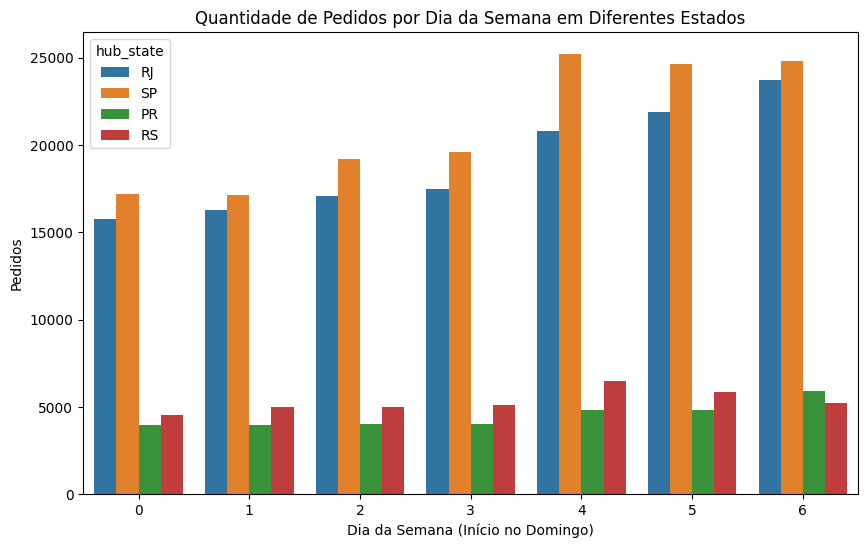

In [25]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
#sns.countplot(x=x_plot, data=df, hue=x_plot, legend=False, palette='viridis')
sns.countplot(x=x_plot, data=df_date, hue='hub_state')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Dia da Semana em Diferentes Estados')
plt.show()

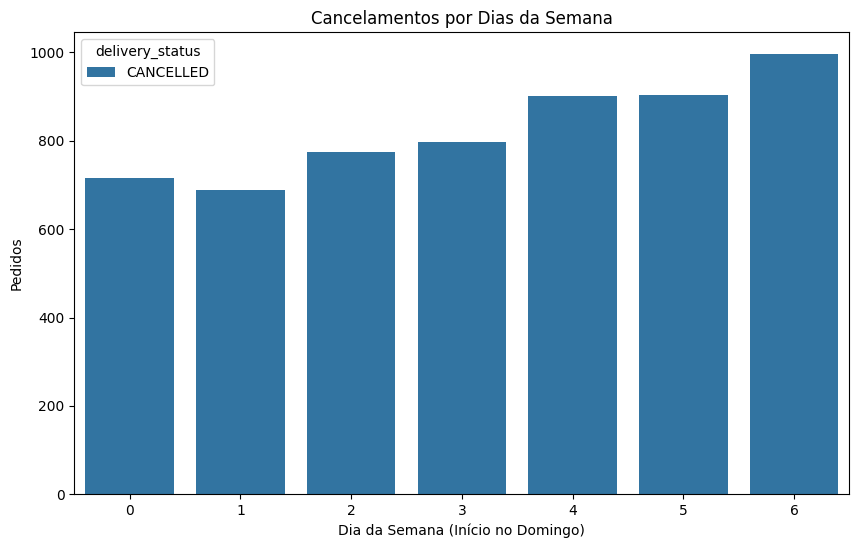

In [26]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date[df_date['delivery_status'].eq('CANCELLED')], hue='delivery_status')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Cancelamentos por Dias da Semana')
plt.show()

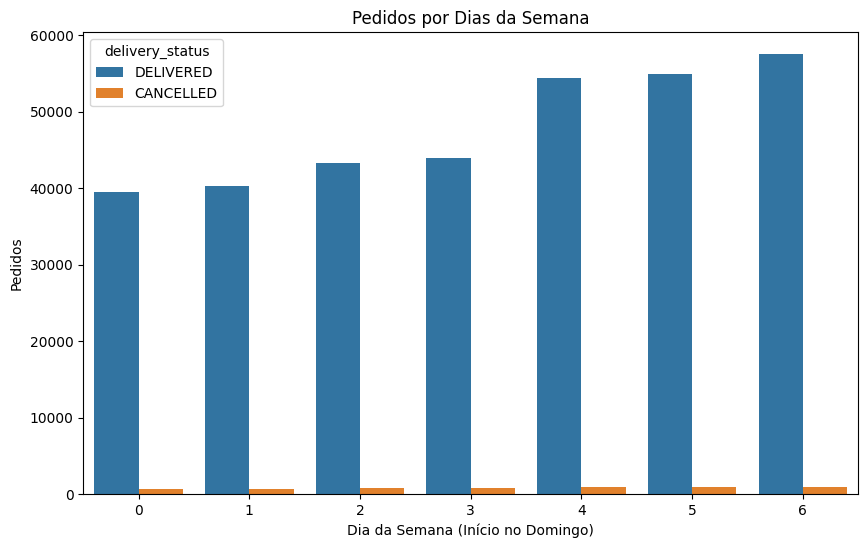

In [27]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date[~df_date['delivery_status'].eq('DELIVERING')], hue='delivery_status')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Pedidos por Dias da Semana')
plt.show()

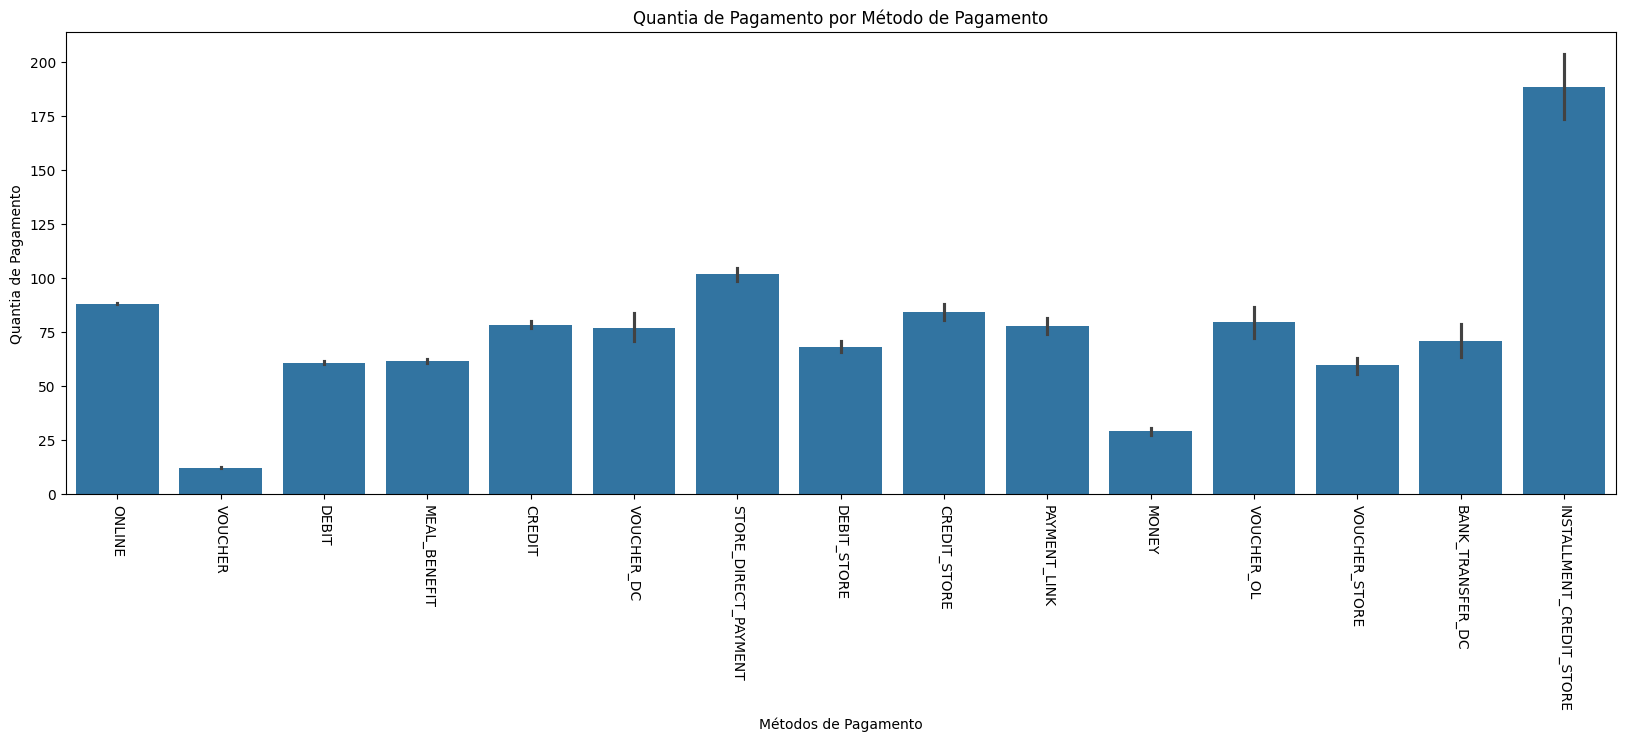

In [28]:
x_plot = 'payment_method'
y_plot = 'payment_amount'

plt.figure(figsize=(20,6))
sns.barplot(x=x_plot, y=y_plot, data=df_date)
plt.xlabel('Métodos de Pagamento')
plt.xticks(rotation=-90)
plt.ylabel('Quantia de Pagamento')
plt.title('Quantia de Pagamento por Método de Pagamento')
plt.show()

# Análise de Correlações com a Variável-Alvo

In [29]:
'''Separando dados numéricos e categóricos '''
numeric_cols = df.select_dtypes(['float','int']).columns
categoric_cols = df.select_dtypes('object').columns

df_numeric = df[numeric_cols]
df_categoric = df[categoric_cols]

In [30]:
df_numeric.corr()['order_metric_cycle_time'].sort_values(ascending=False)

order_metric_cycle_time              1.000000
order_metric_production_time         0.658791
order_metric_transit_time            0.654250
order_metric_expediton_speed_time    0.321011
order_metric_paused_time             0.274041
order_amount                         0.244402
payment_amount                       0.221288
payment_fee                          0.214662
delivery_distance_meters             0.172711
order_delivery_fee                   0.159997
order_metric_walking_time            0.146298
order_metric_collected_time          0.069204
order_delivery_cost                  0.048399
store_plan_price                    -0.098224
Name: order_metric_cycle_time, dtype: float64

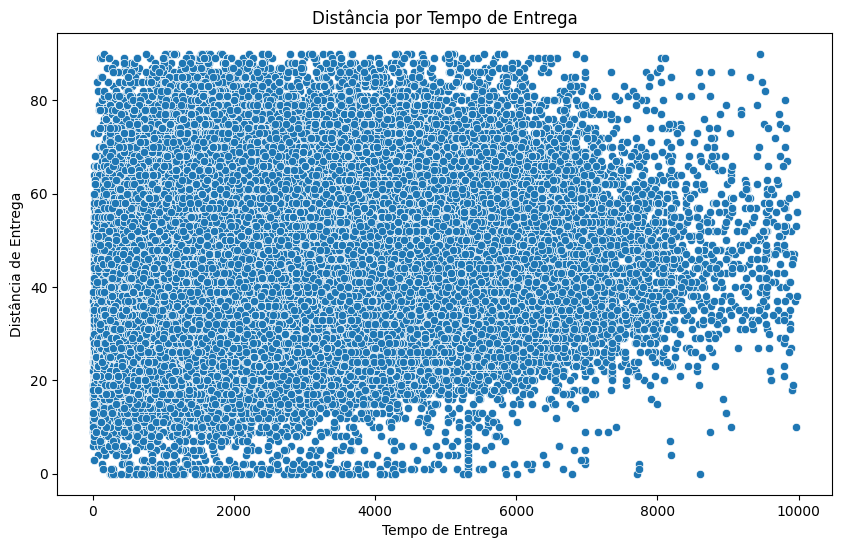

In [31]:
y_plot = 'order_metric_cycle_time'
x_plot = 'delivery_distance_meters'

plt.figure(figsize=(10,6))
sns.scatterplot(x=x_plot,y=y_plot, data=df)
plt.xlabel('Tempo de Entrega')
plt.ylabel('Distância de Entrega')
plt.title('Distância por Tempo de Entrega')
plt.show()

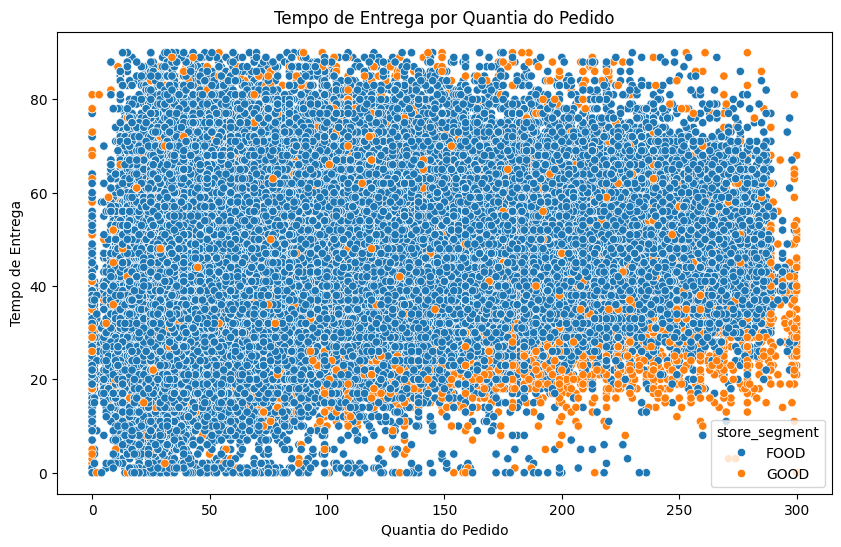

In [32]:
y_plot = 'order_metric_cycle_time'
x_plot = 'order_amount'

plt.figure(figsize=(10,6))
sns.scatterplot(x=x_plot,y=y_plot, data=df, hue='store_segment')
plt.ylabel('Tempo de Entrega')
plt.xlabel('Quantia do Pedido')
plt.title('Tempo de Entrega por Quantia do Pedido')
plt.show()

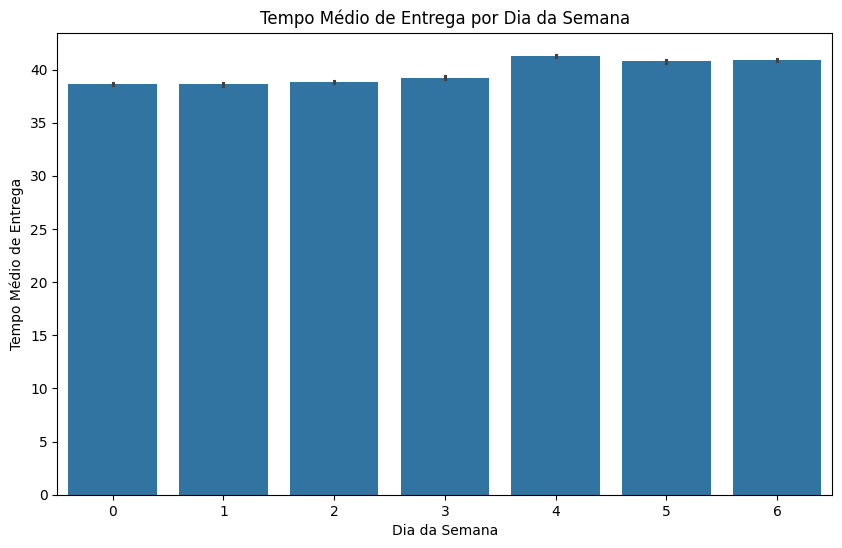

In [33]:
y_plot = 'order_metric_cycle_time'
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date)
plt.xlabel('Dia da Semana')
plt.ylabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Dia da Semana')
plt.show()

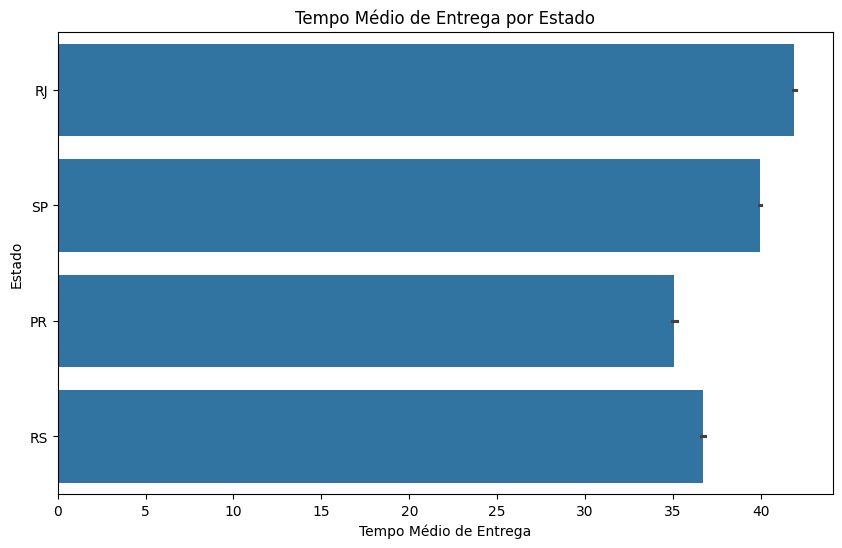

In [34]:
x_plot = 'order_metric_cycle_time'
y_plot = 'hub_state'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, orient='h')
plt.ylabel('Estado')
plt.xlabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Estado')
plt.show()

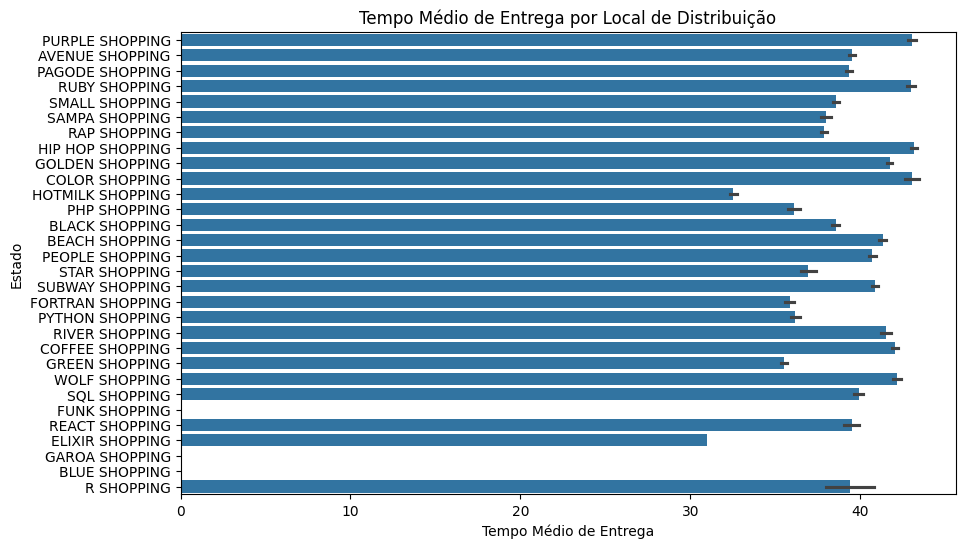

In [35]:
x_plot = 'order_metric_cycle_time'
y_plot = 'hub_name'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, orient='h')
plt.ylabel('Estado')
plt.xlabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Local de Distribuição')
plt.show()

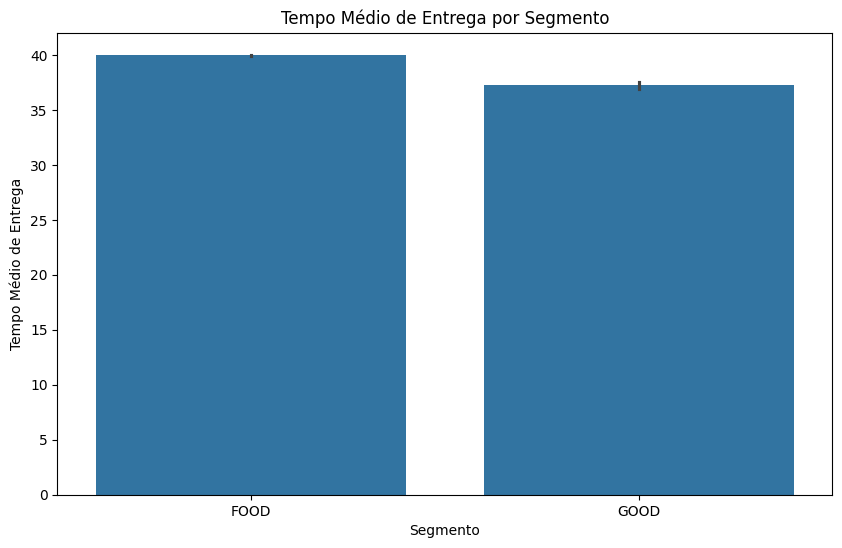

In [36]:
y_plot = 'order_metric_cycle_time'
x_plot = 'store_segment'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date)
plt.xlabel('Segmento')
plt.ylabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Segmento')
plt.show()

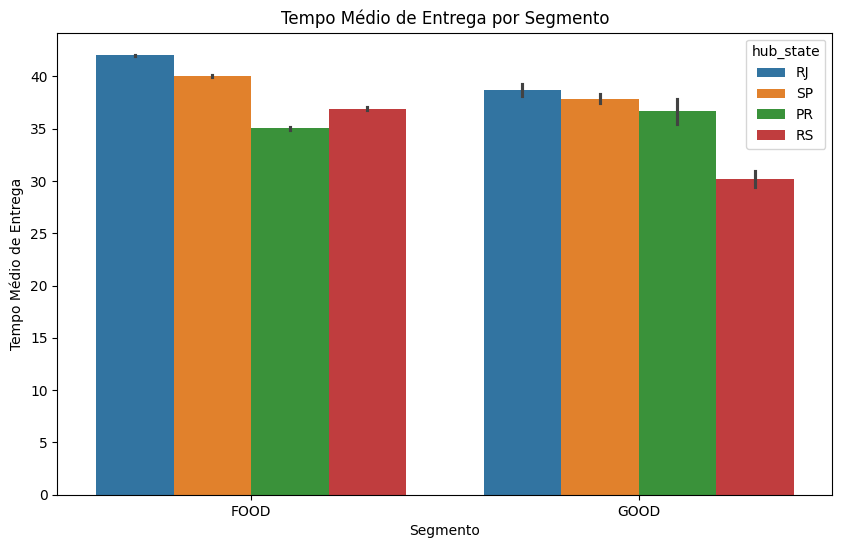

In [37]:
y_plot = 'order_metric_cycle_time'
x_plot = 'store_segment'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, hue='hub_state')
plt.xlabel('Segmento')
plt.ylabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Segmento')
plt.show()

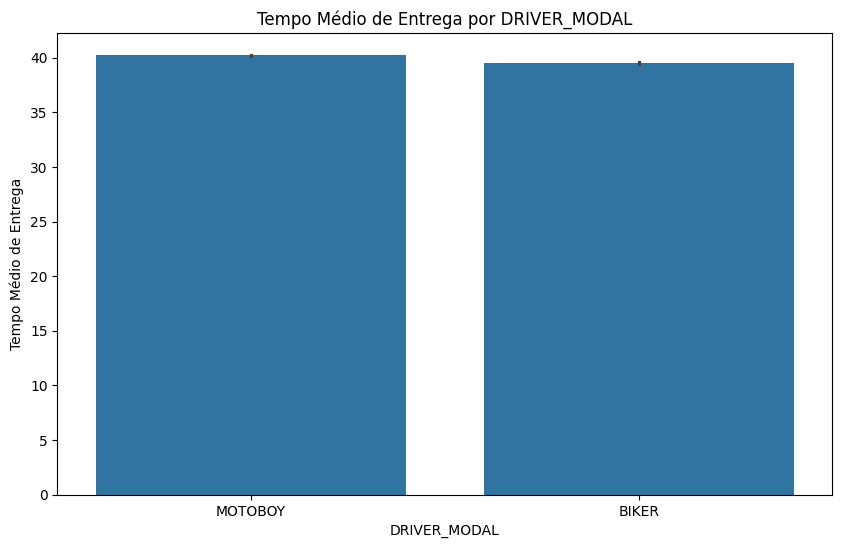

In [38]:
y_plot = 'order_metric_cycle_time'
x_plot = 'driver_modal'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date)
plt.xlabel('DRIVER_MODAL')
plt.ylabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por DRIVER_MODAL')
plt.show()

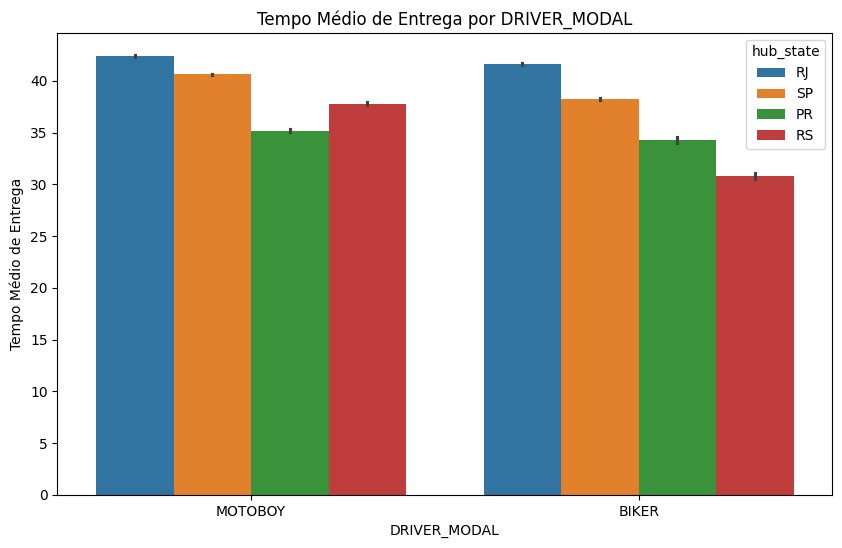

In [39]:
y_plot = 'order_metric_cycle_time'
x_plot = 'driver_modal'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, hue='hub_state')
plt.xlabel('DRIVER_MODAL')
plt.ylabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por DRIVER_MODAL')
plt.show()

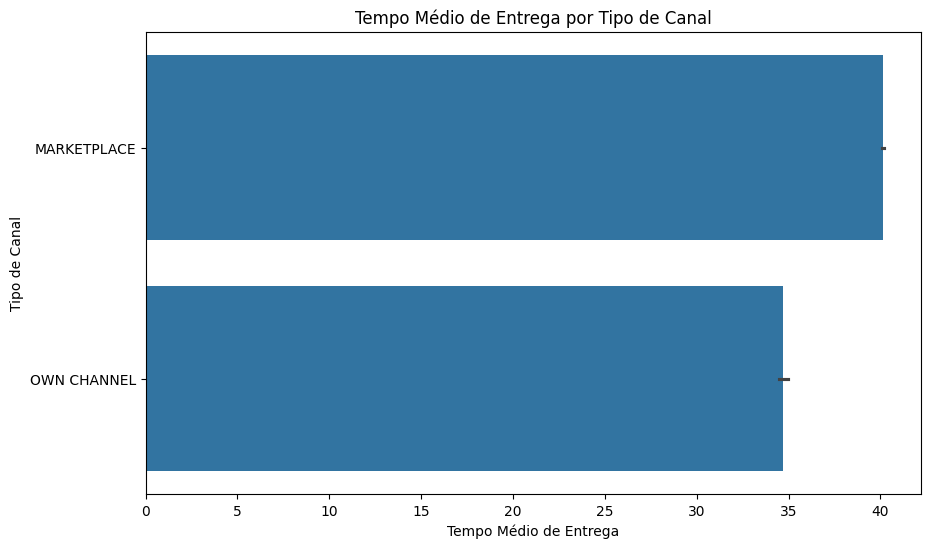

In [40]:
x_plot = 'order_metric_cycle_time'
y_plot = 'channel_type'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, orient='h')
plt.ylabel('Tipo de Canal')
plt.xlabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Tipo de Canal')
plt.show()

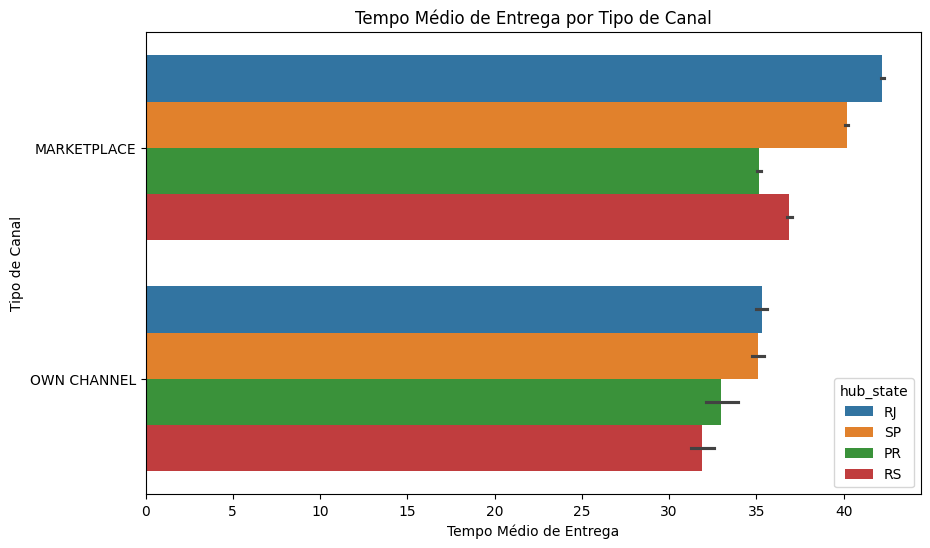

In [41]:
x_plot = 'order_metric_cycle_time'
y_plot = 'channel_type'

plt.figure(figsize=(10,6))
sns.barplot(x=x_plot,y=y_plot, data=df_date, orient='h', hue='hub_state')
plt.ylabel('Tipo de Canal')
plt.xlabel('Tempo Médio de Entrega')
plt.title('Tempo Médio de Entrega por Tipo de Canal')
plt.show()

In [42]:
df.columns

Index(['hub_name', 'hub_city', 'hub_state', 'store_name', 'store_segment',
       'store_plan_price', 'driver_modal', 'driver_type',
       'delivery_distance_meters', 'delivery_status', 'payment_amount',
       'payment_fee', 'payment_method', 'payment_status', 'channel_name',
       'channel_type', 'order_status', 'order_amount', 'order_delivery_fee',
       'order_delivery_cost', 'order_moment_created', 'order_moment_accepted',
       'order_moment_ready', 'order_moment_collected',
       'order_moment_in_expedition', 'order_moment_delivering',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'order_date'],
      dtype='object')

Correlação entre payment_amount e payment_fee: 0.9257544905459253
Correlação entre payment_amount e order_amount: 0.9209249073419354
Correlação entre payment_fee e order_amount: 0.8431018098941655
Correlação entre order_metric_paused_time e order_metric_expediton_speed_time: 0.8133473704373997


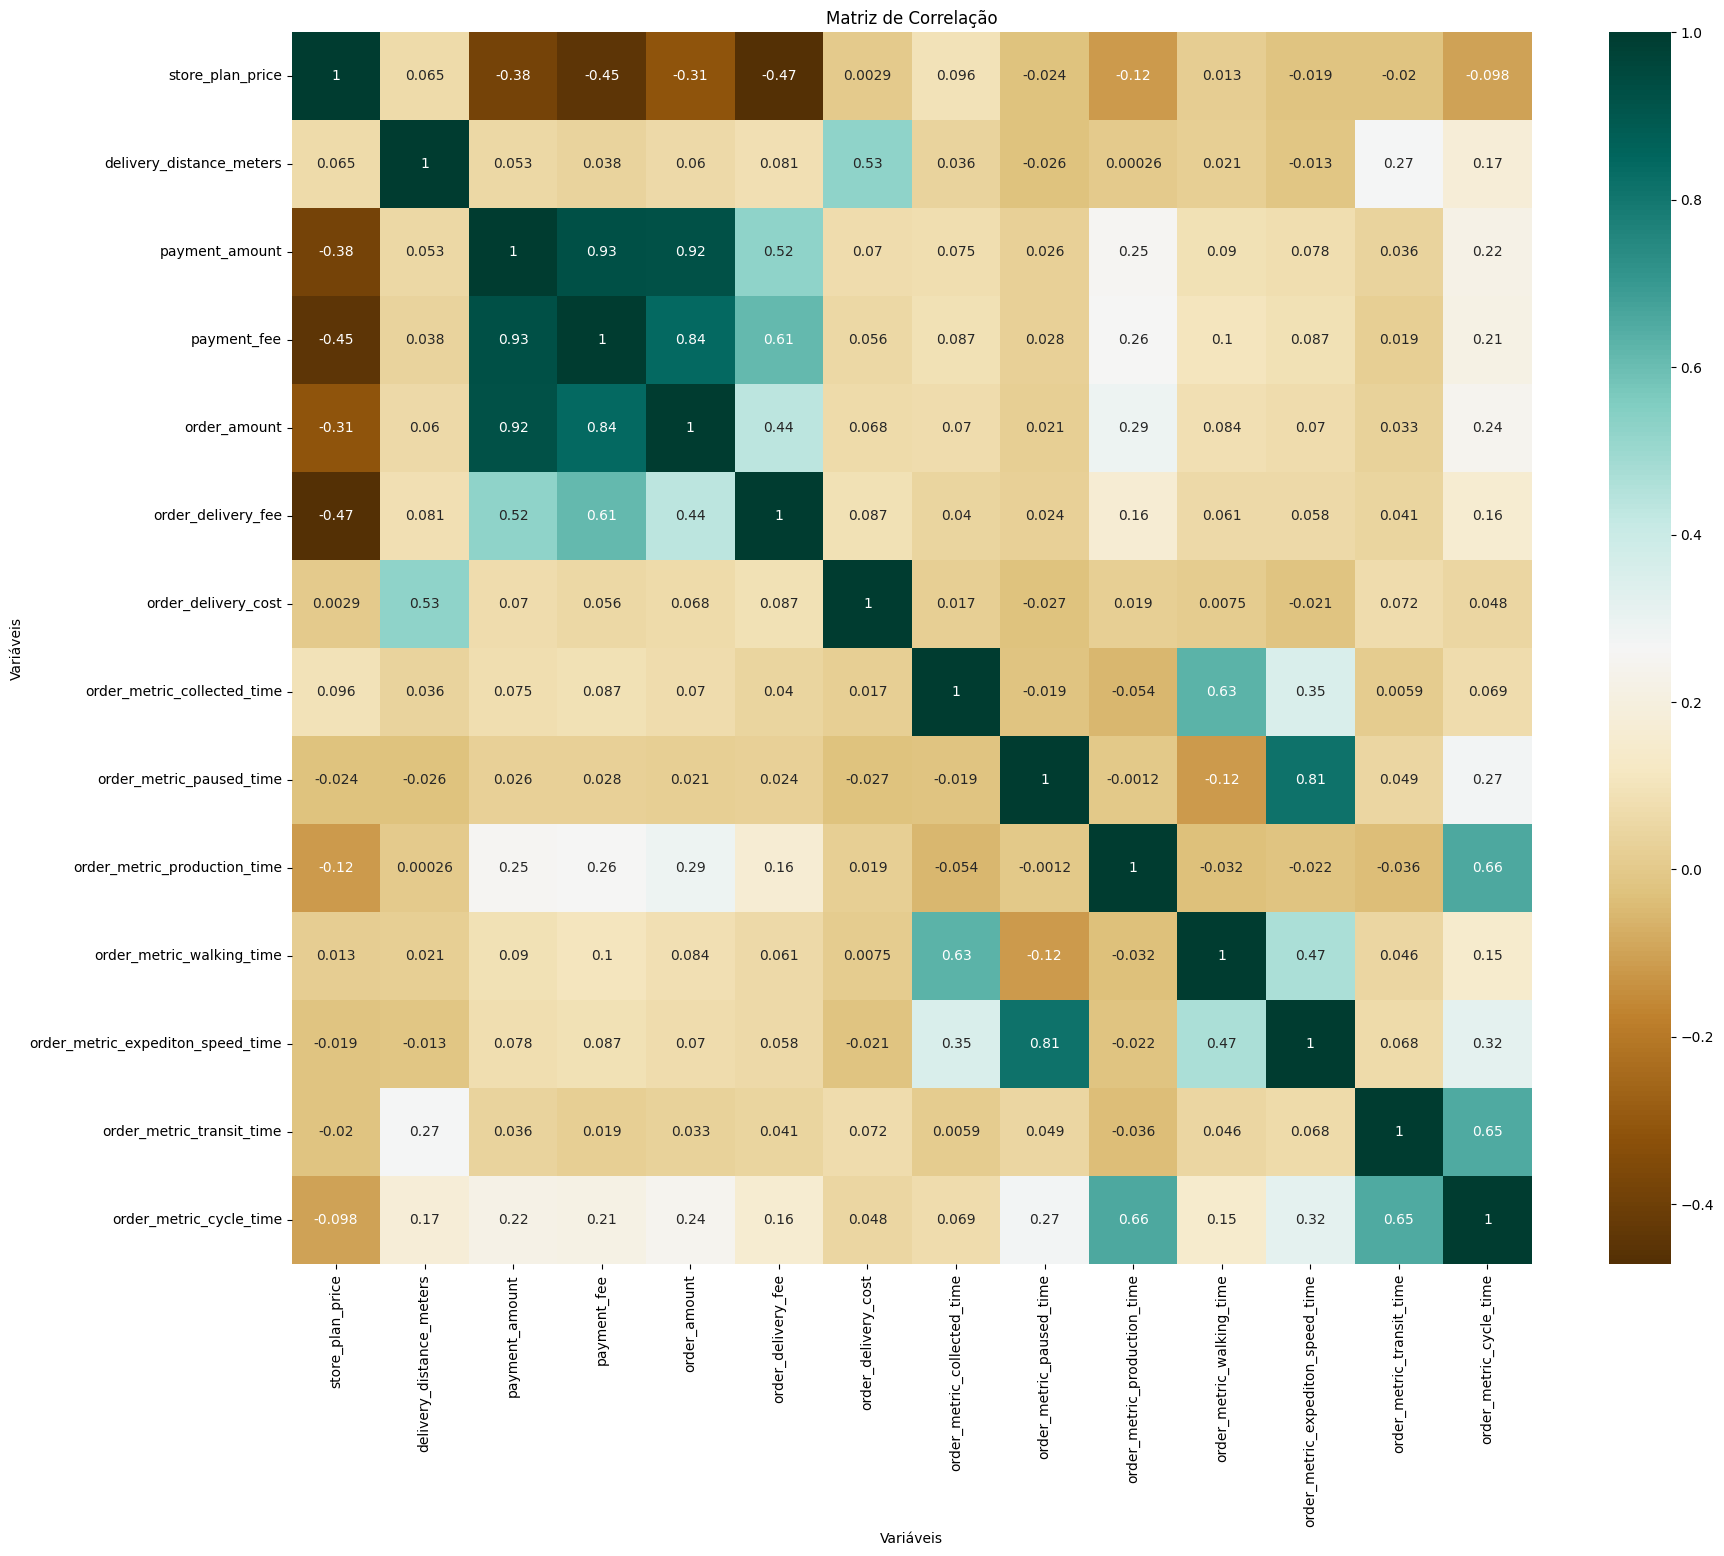

[('payment_amount', 'payment_fee'),
 ('payment_amount', 'order_amount'),
 ('payment_fee', 'order_amount'),
 ('order_metric_paused_time', 'order_metric_expediton_speed_time')]

In [43]:
corr_interval = (0.7, 1.0)
find_correlated_columns(df_numeric, corr_interval)

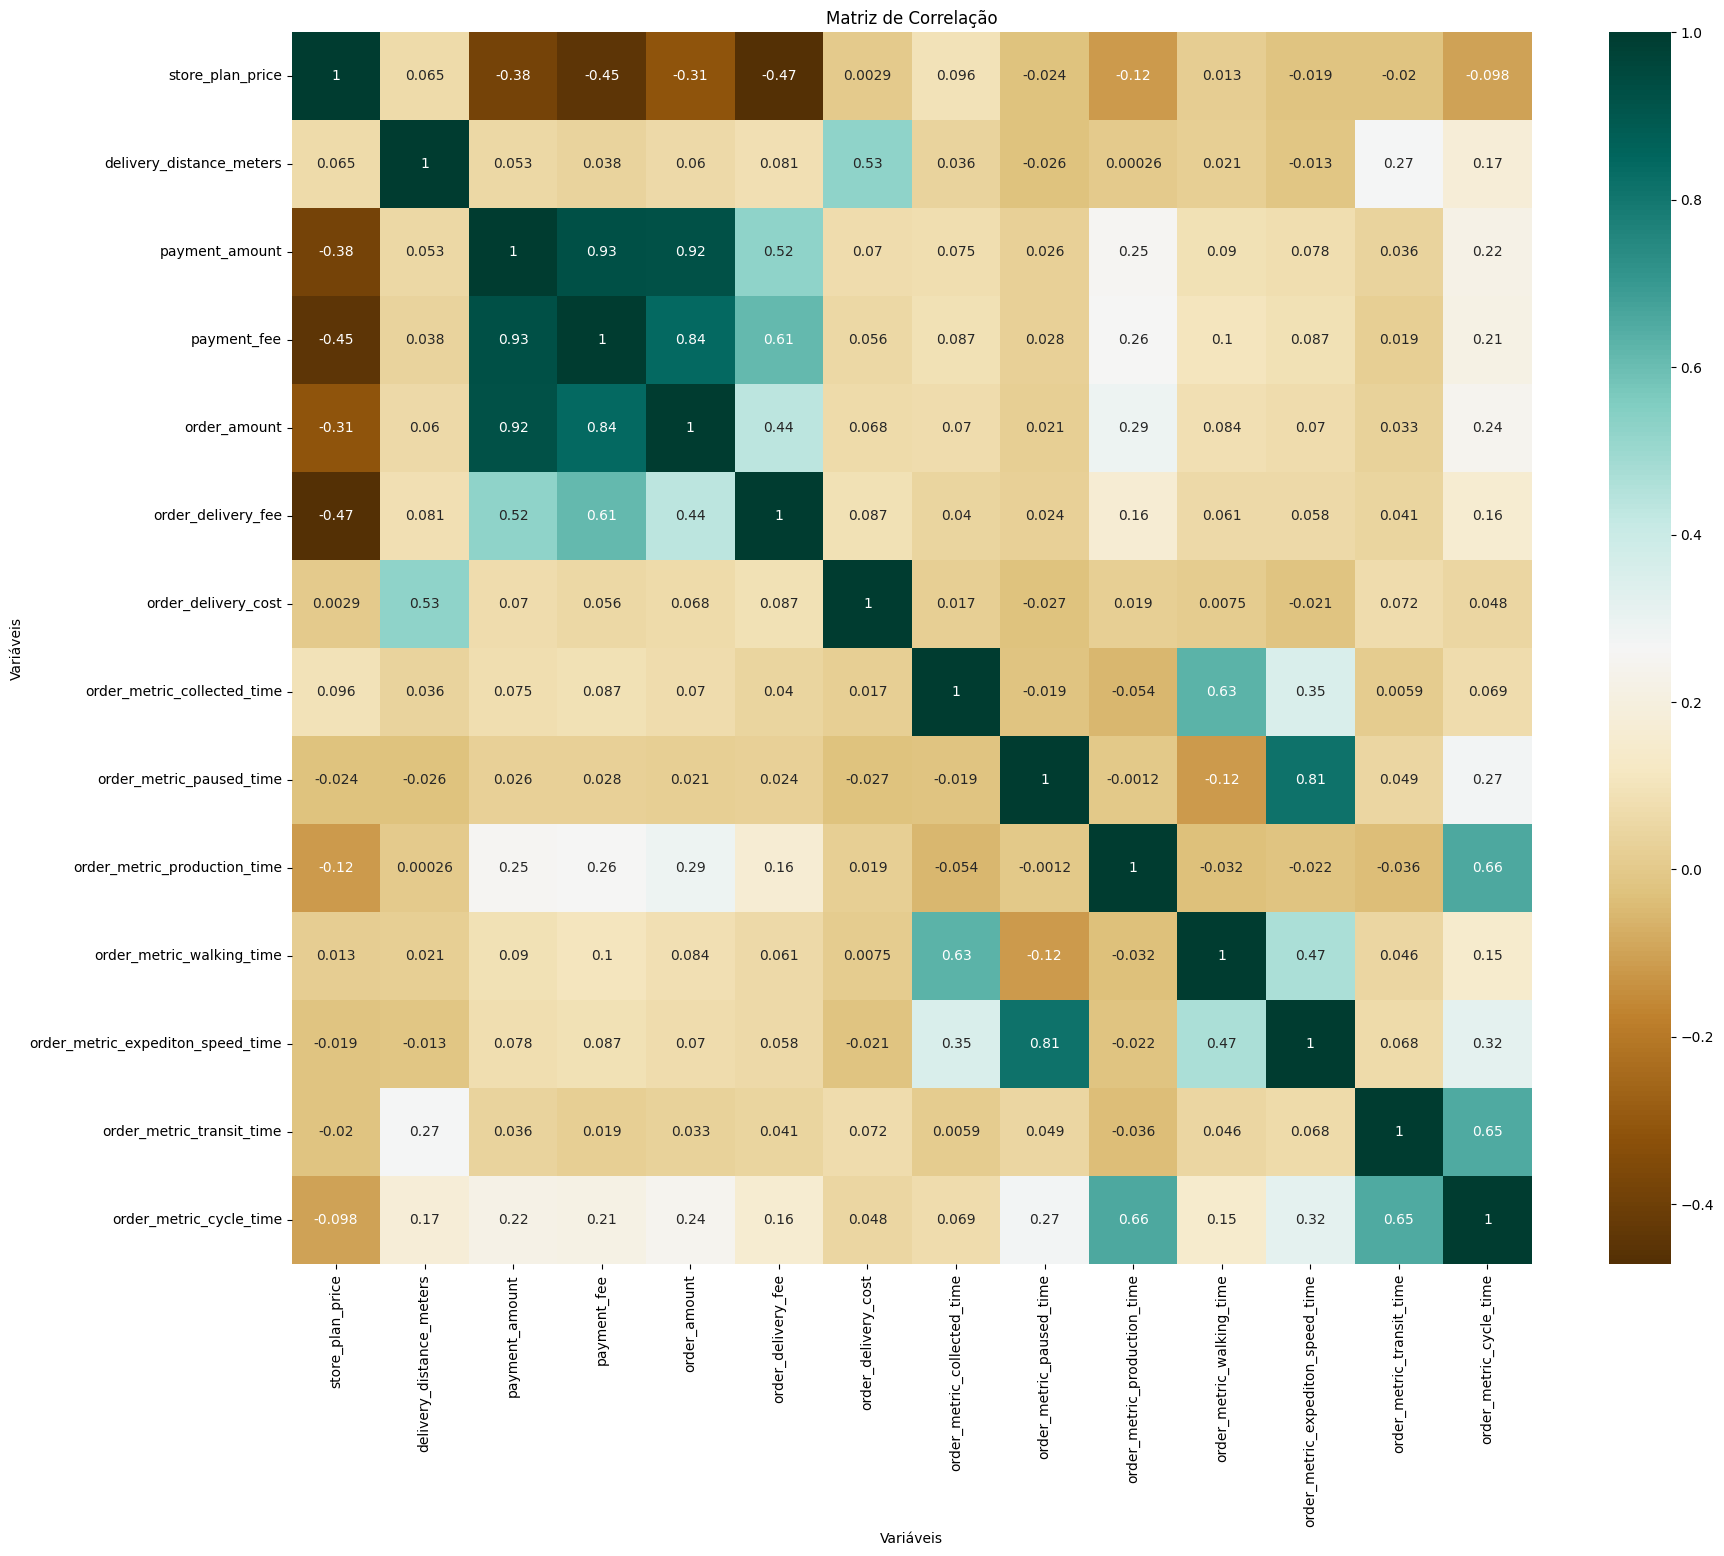

[]

In [44]:
corr_interval = (-1, -0.7)
find_correlated_columns(df_numeric, corr_interval)

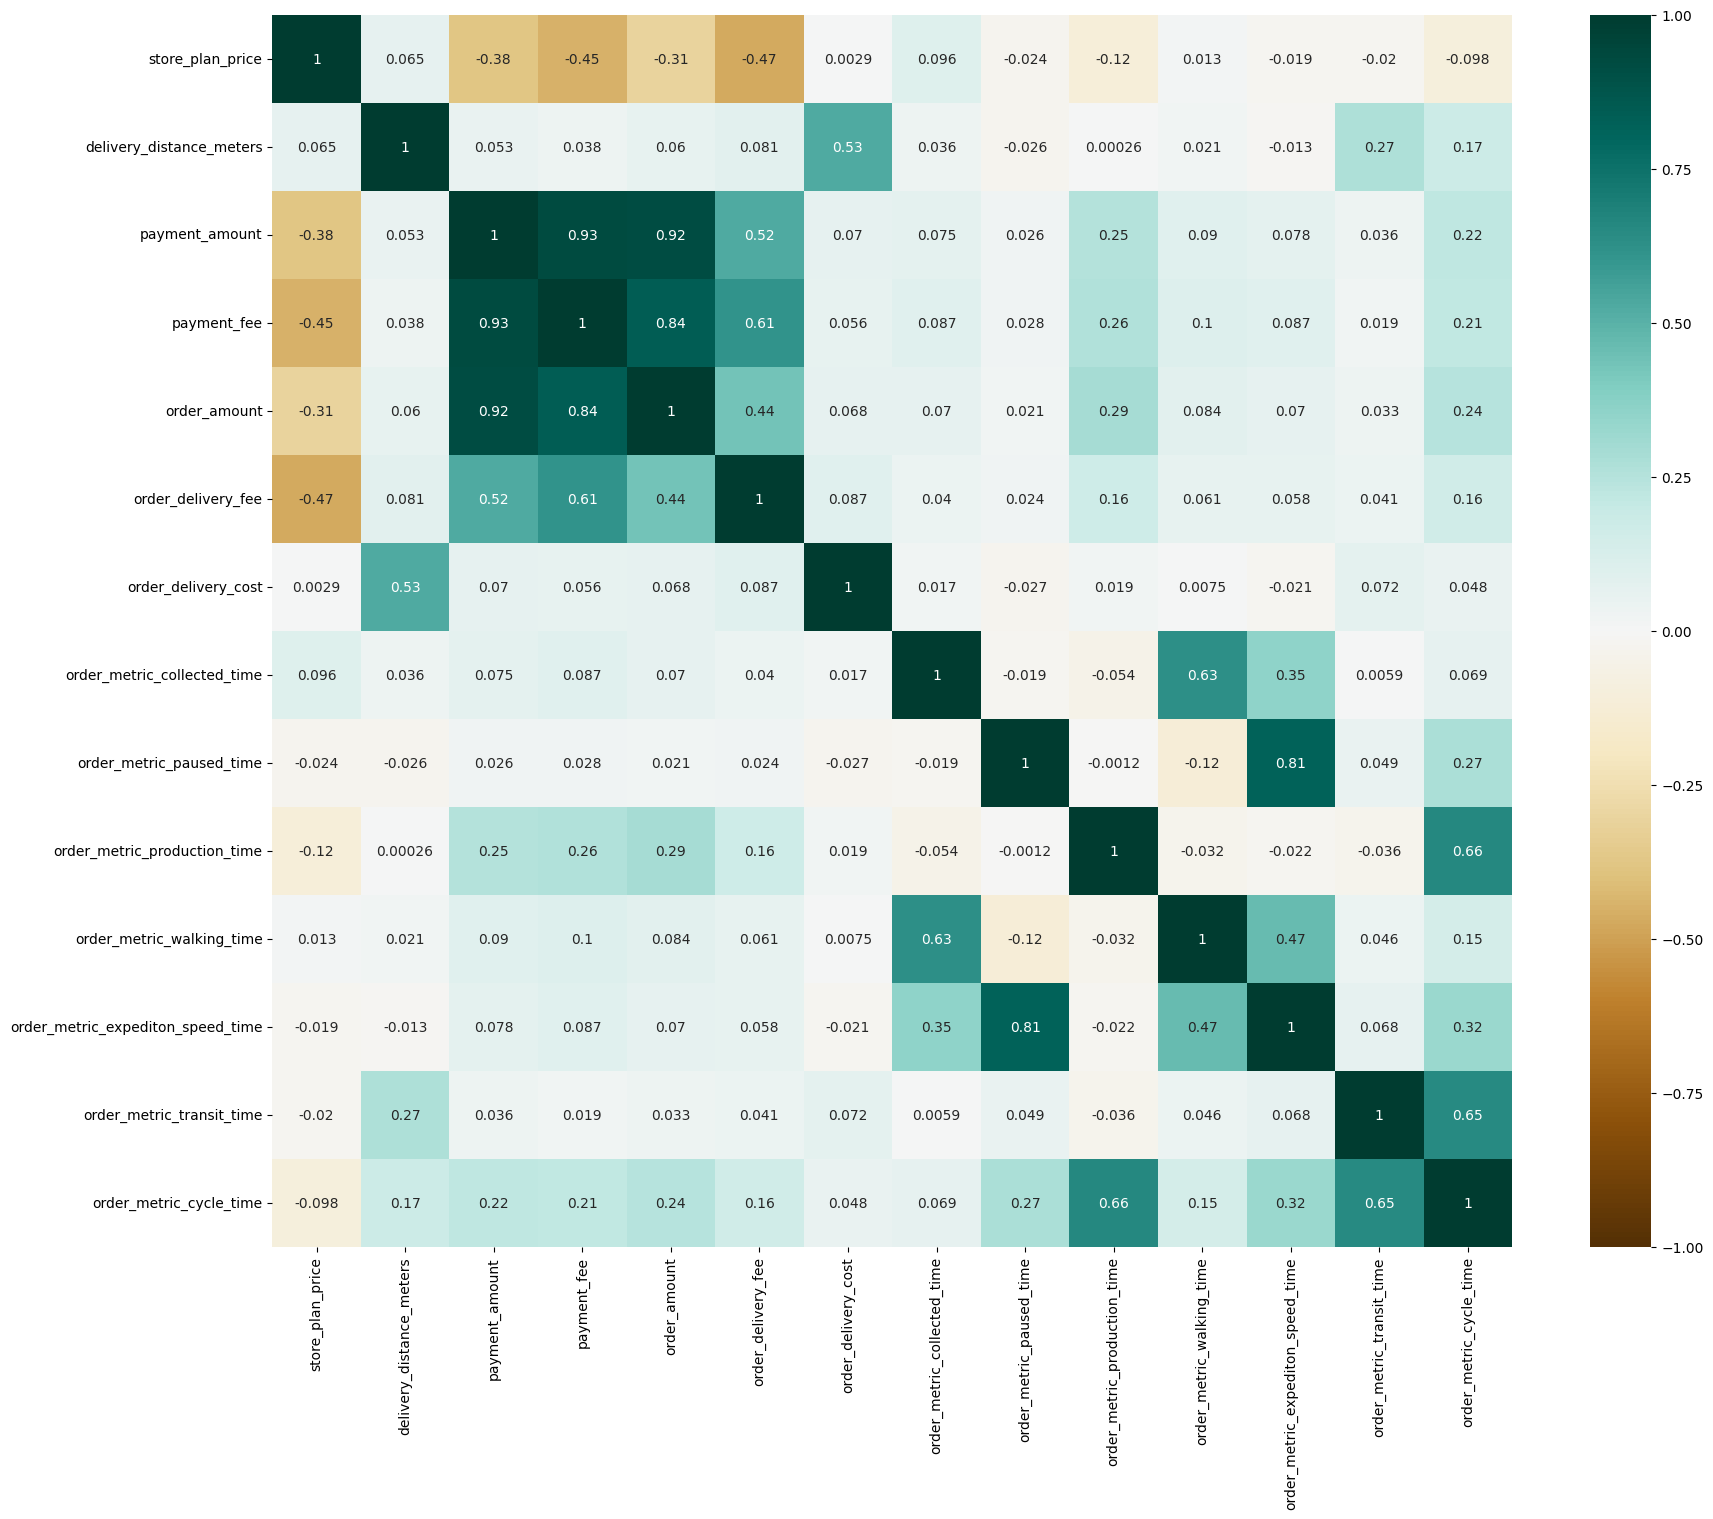

In [45]:
plt.figure(figsize=(20, 16))
sns.heatmap(df_numeric.corr(),annot=True, vmin=-1, vmax=1,cmap='BrBG') 
plt.show()